In [1]:
!pip install pandas_datareader
!pip install --upgrade pandas

In [2]:
import pandas as pd
import datetime as dt
from pandas_datareader import data as datard
import mplfinance as mpf

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#apikey = '取得したAPIキー'
apikey = 'KDDTQTNE9OTMD4V4.'
symbol = 'EURUSD'

start = dt.date(2019,1,1)
end = dt.date(2022,2,3)

df = datard.DataReader(symbol,'av-daily',start,end, api_key=apikey)

In [3]:
df['volume']=0.1 

In [4]:
import numpy
#df = df.apply(numpy.log)
from scipy.stats import boxcox
df2,_ = boxcox(df['close'])

In [5]:
df=df.assign(open=df2,high=df2,low=df2,close=df2)

In [6]:
wsize=50 #サンプル期間
after=5 #最終レコード＋α
change_large = 5 #変化大　4%

In [7]:
import pdb
df.index = pd.DatetimeIndex(df.index)

alldata =[]

for time in range(len(df)-wsize-1):
    try:
        dfspan = df[time:time+wsize]
        alldata.append({"df":dfspan,"date":dfspan.tail(1)})
    except:
        pass

In [8]:
class ImageTransform():
  def __init__(self, mean, std):
    self.data_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

  def __call__(self, img):
    return self.data_transform(img)

In [9]:
import torch
from torchvision.datasets import ImageFolder
import torch.utils.data as data
from torchvision import models, transforms
import torch.nn as nn
from PIL import Image, ImageFilter

model = models.vgg16(pretrained=True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_ftrs,  out_features=3)
model.load_state_dict(torch.load('model_state.pth'))
model.eval()

#画像データをImageFolderを使って取込みする
#mean=[0.485, 0.456, 0.406]
#std=[0.229, 0.224, 0.225]
mean = (0.5,)
std = (0.5,)
new_dir_path = 'predict'

sma_s= 20
sma_m= 25

cs  = mpf.make_mpf_style(base_mpl_style='dark_background',gridcolor="#000000",mavcolors=['#00ff00','#0000ff'], facecolor="#000000")

In [10]:
def Imagesrc(datestr):
    
    search_df = [x['df'] for x in alldata if x['date'].index == datestr]
    transform = ImageTransform(mean, std)

    if search_df:
        mpf.plot(search_df[0],savefig= 'predict.png',mav=(sma_s,sma_m),figsize=(2.5,2.5), type='line',\
             figratio=(12,4),style=cs,axisoff=True,\
             linecolor='#ff0000',tight_layout=True)
        img = Image.open('predict.png').convert('RGB')
        img_transform = transform(img)
        inputs = img_transform.unsqueeze_(0)

        result = model(inputs)
        idx = torch.argmax(result[0])
        return img_transform,idx.numpy()
    else:
        img=Image.new("RGB", (800, 1280), (255, 255, 255))
        img_transform = transform(img)
        inputs = img_transform.unsqueeze_(0)

        result = model(inputs)
        idx = torch.argmax(result[0])
        return img_transform,idx.numpy()
    

In [11]:
img,label = Imagesrc("2022-01-01")
#バッチから取り出した画像の大きさを確認する
print("image shape ==>;",img.shape)

image shape ==>; torch.Size([1, 3, 224, 224])


Label is  2


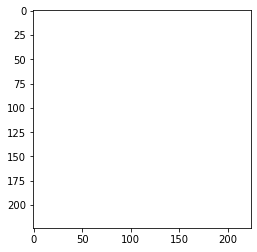

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

#バッチから取り出した画像のイメージとラベルを表示する
pic = transforms.ToPILImage(mode='RGB')(img[0])
plt.imshow(pic)
print("Label is ",label)

In [13]:
!pip install backtesting

In [14]:
df=df.set_axis(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm

start = dt.date(2020,4,1)
end = dt.date(2022,2,3)

realdf = datard.DataReader(symbol,'av-daily',start,end, api_key=apikey)
realdf=realdf.set_axis(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
realdf.index = pd.DatetimeIndex(realdf.index)

signal= []
    
for index, row in tqdm.tqdm(realdf.iterrows()):
    img,label = Imagesrc(index)
    signal.append(label)

482it [02:28,  3.25it/s]


In [16]:
realdf['signal']=signal

In [17]:
realdf

,Open,High,Low,Close,Volume,signal
2020-04-01,1.1023,1.1037,1.0901,1.0956,0,2
2020-04-02,1.0956,1.0964,1.0819,1.0850,0,2
2020-04-03,1.0850,1.0855,1.0771,1.0812,0,2
2020-04-06,1.0817,1.0836,1.0767,1.0785,0,2
2020-04-07,1.0785,1.0926,1.0783,1.0892,0,2
...,...,...,...,...,...,...
2022-01-28,1.1143,1.1174,1.1120,1.1146,0,2
2022-01-31,1.1141,1.1248,1.1137,1.1233,0,2
2022-02-01,1.1235,1.1279,1.1219,1.1270,0,2
2022-02-02,1.1271,1.1330,1.1264,1.1302,0,2


In [18]:
from backtesting import Backtest, Strategy
from backtesting.lib import SignalStrategy, TrailingStrategy

def SIGNAL():
    return realdf.signal

class VGG16EVA(Strategy):
    stls=0.03
    tkpf=0.02
    
    def init(self):
        self.signal1=self.I(SIGNAL)
        pass
    
    def next(self): #チャートデータの行ごとに呼び出される
        super().next()
        stls = self.stls
        tkpf = self.tkpf

        if self.signal1==0:

            sl1= self.data.Close[-1] - stls
            tp1= self.data.Close[-1] + tkpf
            self.buy(sl=sl1,tp=tp1) # 買い
            
        elif self.signal1==1:
 
            sl1= self.data.Close[-1] + stls
            tp1= self.data.Close[-1] - tkpf
            self.sell(sl=sl1,tp=tp1)# 売り
    
bt = Backtest(
    realdf, # チャートデータ
    VGG16EVA, # 売買戦略
    cash=100000, # 最初の所持金
    commission=0.00495, # 取引手数料
    margin=1.0, # レバレッジ倍率の逆数（0.5で2倍レバレッジ）
    trade_on_close=True, # True：現在の終値で取引，False：次の時間の始値で取引
   
)

output = bt.run() # バックテスト実行
print(output) # 実行結果(データ)
bt.plot() # 実行結果（グラフ）

C:\Users\User\anaconda3\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

Start                     2020-04-01 00:00:00
End                       2022-02-03 00:00:00
Duration                    673 days 00:00:00
Exposure Time [%]                   22.406639
Equity Final [$]                 97538.570041
Equity Peak [$]                 101227.522191
Return [%]                           -2.46143
Buy & Hold Return [%]                4.417671
Return (Ann.) [%]                   -1.294539
Volatility (Ann.) [%]                2.511445
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -4.965661
Avg. Drawdown [%]                   -2.595803
Max. Drawdown Duration      204 days 00:00:00
Avg. Drawdown Duration      103 days 00:00:00
# Trades                                    3
Win Rate [%]                        33.333333
Best Trade [%]                       1.227532
Worst Trade [%]                      -3.01493
Avg. Trade [%]                    

Row(id='1475', ...)